# Introduction
Continuing from the last time, we will continue training and estimation of the TGS Salt Identification Challeng dataset.


TGS Salt Identification Challenge | Kaggle



In [1]:
# imports
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications import VGG16

%matplotlib inline

F:\AppSSD\WorkTools\Anaconda\envs\tensorflow1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
F:\AppSSD\WorkTools\Anaconda\envs\tensorflow1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
F:\AppSSD\WorkTools\Anaconda\envs\tensorflow1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
F:\AppSSD\WorkTools\Anaconda\en

# Data
I've re-structure data and only use 1000 img in train and 1000 img in test

In [2]:
DATA_PATH = '../Data/Big/small_salt_data'

In [3]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
test = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
depth = pd.read_csv(f'{DATA_PATH}/depths.csv')

train_src = f'{DATA_PATH}/train/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))


train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))

train:
           id                                           rle_mask
0  668b41c03e  5455 1 5556 3 5657 5 5758 7 5859 8 5960 9 6061...
1  fa752c35ca  1 9191 9193 100 9295 99 9398 97 9501 95 9604 9...
2  73a2f6fb22  1 4 102 6 203 8 304 13 405 19 506 23 607 25 70...
3  739a9ab34a                                            10200 2
4  a568cc8273  1942 5 2043 8 2144 12 2245 15 2346 18 2446 23 ...

test:
           id rle_mask
0  02337f94a9      1 1
1  952563a97e      1 1
2  068f7a5267      1 1
3  0e8e9e9b41      1 1
4  f2f055154d      1 1

           id                                           rle_mask    z
0  668b41c03e  5455 1 5556 3 5657 5 5758 7 5859 8 5960 9 6061...  659
1  fa752c35ca  1 9191 9193 100 9295 99 9398 97 9501 95 9604 9...  300
2  73a2f6fb22  1 4 102 6 203 8 304 13 405 19 506 23 607 25 70...  642
3  739a9ab34a                                            10200 2  435
4  a568cc8273  1942 5 2043 8 2144 12 2245 15 2346 18 2446 23 ...  626


In [4]:
X_train = np.asarray(
    [cv2.imread(f'{DATA_PATH}/train/images/{x}.png', 0) for x in train.id.tolist()], 
    dtype=np.uint8) / 255.
y_train = np.asarray(
    [cv2.imread(f'{DATA_PATH}/train/masks/{x}.png', 0) for x in train.id.tolist()],
    dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape)

(1000, 101, 101) (1000, 101, 101)


# Problem 1
Code review

## Let's run RESNET50 Code

In [5]:
def compute_coverage(df, masks):
    
    df = df.copy()
    
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

### Prep data

In [6]:
train = compute_coverage(train, y_train)
kfold = StratifiedKFold(n_splits=5)

# Add channel features
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# Resize to 224x224, default ResNet50 image size
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))


for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

(800, 224, 224, 3) (800, 224, 224, 1)
(200, 224, 224, 3) (200, 224, 224, 1)


25

### Losses and Metrics

In [7]:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

### Base model Resnet50

In [8]:
import re


# ! Important helper function i yanked from stackoverflow to help with adding layer to pretrained model
def insert_layer_nonseq(model, layer_regex, insert_layer_factory,
                        insert_layer_name=None, position='after'):

    # Auxiliary dictionary to describe the network graph
    network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer.outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    model_outputs = []
    added = False
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if re.match(layer_regex, layer.name) and not added:
            if position == 'replace':
                x = layer_input
            elif position == 'after':
                x = layer(layer_input)
            elif position == 'before':
                pass
            else:
                raise ValueError('position must be: before, after or replace')

            new_layer = insert_layer_factory
            if insert_layer_name:
                new_layer.name = insert_layer_name
            else:
                new_layer.name = '{}_{}'.format(layer.name, 
                                                new_layer.name)
            x = new_layer(x)
            print('New layer: {} Old layer: {} Type: {}'.format(new_layer.name,
                                                            layer.name, position))
            if position == 'before':
                x = layer(x)
            added = True
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

        # Save tensor in output list if it is output in initial model
        if layer_name in model.output_names:
            model_outputs.append(x)

    return Model(inputs=model.inputs, outputs=model_outputs)

In [9]:
input_size = (224, 224, 3)
resnet_50 = ResNet50(input_shape=input_size, include_top=False)
model = insert_layer_nonseq(resnet_50, '.*activation.*', ZeroPadding2D())

# # Fix possible problems with new model
# # model.save('temp.hdf5')
# # model = load_model('temp.hdf5')

model.summary()








New layer: activation_1_zero_padding2d_1 Old layer: activation_1 Type: after
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[1][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[1][0]                   
_______

### NOTE
- Notice above that many dimension is shown as multiple, not a number
- This just need a model save + reload to fix 
- But it take some time so i comment that part out in above code

### Model Resnet + Unet

In [10]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        padding='same'):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding=padding,
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

In [11]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    resnet_50 = ResNet50(input_shape=input_size,weights=weights, include_top=False, pooling=None)
    added_model = insert_layer_nonseq(resnet_50, '.*activation.*', ZeroPadding2D())
    # Fix possible problems with new model
    added_model.save('temp.hdf5')
    added_model = load_model('temp.hdf5')
    output = added_model.layers[-2].output
    base_model = Model(inputs=added_model.input, outputs=output)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('conv1').output # activation_1
    encoder2 = base_model.get_layer('res2c_branch2c').output # activation_10
    encoder3 = base_model.get_layer('res3d_branch2c').output # activation_22
    encoder4 = base_model.get_layer('res4f_branch2c').output # activation_40
    encoder5 = base_model.get_layer('res5c_branch2c').output # activation_40


    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    print('enc: ', [x for x in [encoder1, encoder2, encoder3,encoder4, encoder5]])
    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    print('de: ', [x for x in [decoder2, decoder3,decoder4]])
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### Test Train

In [12]:
input_size = (224, 224, 3)
K.clear_session()

resnet = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(resnet.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)

New layer: activation_1_zero_padding2d_1 Old layer: activation_1 Type: after
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


F:\AppSSD\WorkTools\Anaconda\envs\tensorflow1-gpu\lib\site-packages\keras\models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



enc:  [<tf.Tensor 'conv1_2/BiasAdd:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'res2c_branch2c_2/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'res3d_branch2c_2/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'res4f_branch2c_2/BiasAdd:0' shape=(?, 14, 14, 1024) dtype=float32>, <tf.Tensor 'res5c_branch2c_2/BiasAdd:0' shape=(?, 7, 7, 2048) dtype=float32>]
de:  [<tf.Tensor 'add_20/add:0' shape=(?, 28, 28, 64) dtype=float32>, <tf.Tensor 'add_19/add:0' shape=(?, 14, 14, 128) dtype=float32>, <tf.Tensor 'add_18/add:0' shape=(?, 7, 7, 256) dtype=float32>]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to con

In [13]:
epochs = 10  # 1 epoch for testing only
batch_size = 5

history = resnet.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 166s - loss: 0.8276 - my_iou_metric: 0.3256 - val_loss: 5.6775 - val_my_iou_metric: 0.2305
Epoch 2/10
800/800 [==============================] - 80s - loss: 0.6870 - my_iou_metric: 0.4065 - val_loss: 4.1125 - val_my_iou_metric: 0.2305
Epoch 3/10
800/800 [==============================] - 80s - loss: 0.6381 - my_iou_metric: 0.4292 - val_loss: 2.1607 - val_my_iou_metric: 0.2305
Epoch 4/10
800/800 [==============================] - 84s - loss: 0.5978 - my_iou_metric: 0.4573 - val_loss: 7.9653 - val_my_iou_metric: 0.2305
Epoch 5/10
800/800 [==============================] - 82s - loss: 0.4793 - my_iou_metric: 0.5065 - val_loss: 4.9617 - val_my_iou_metric: 0.2420
Epoch 6/10
800/800 [==============================] - 86s - loss: 0.5082 - my_iou_metric: 0.5075 - val_loss: 1.5857

### NOTE
There are changes i made to make the code run
- RESNet 50 has been changed by keras which makes the training model have slight different shape -> cant run code
- So i have add a missing padding layer into the keras's pretrained RESNET 50 to make it work

### Difference with last implementation
**Last implementation was U-net**
- Last implementation, I trained the unet model from start with random init weights but now we use weight from keras's implementation instead
- Also current implementation is the combination resnet with unet architecture 

### How transfer learning was done
- By loading pretrained weights
- And use those weights as init value for training in current dataset

# Problem 2
Code rewrite

**Let's modify the encoder from ResNet to VGG16**

### Base Model

In [14]:
from keras.applications import VGG16

input_size = (224, 224, 3)
model = VGG16(weights=None,input_shape = input_size)
model.summary()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
blo

### VGG16 + UNET

In [15]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_vgg16(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    # resnet_50 = ResNet50(input_shape=input_size, include_top=False, pooling=None)
    vgg_16 = VGG16(input_shape = input_size, weights=weights)
    base_model = vgg_16
    # print(base_model.summary())
    
    # Layers for feature extraction in the encoder part
    encoder2 = base_model.get_layer('block2_conv2').output # before block 2 pooling, 128
    encoder3 = base_model.get_layer('block3_conv3').output # before block 3 pooling, 256
    encoder4 = base_model.get_layer('block4_conv3').output # before block 4 pooling, 512
    encoder5 = base_model.get_layer('block5_conv3').output # before block 5 pooling, 512


    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=512)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=256)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=128)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    output = UpSampling2D()(concat2)
    output = decoder_block(
        output, 'decoder_output', num_filters=64)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### NOTE:
On Unet + VGG16 implementation:
- Center block is 512 filters
- And we have 4 upsamples
- 3 from normal encoder
- plus one last at the decoder output
- Output shape matches (224,224,1)

In [16]:
input_size = (224, 224, 3)
K.clear_session()

vgg16 = unet_vgg16(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(vgg16.summary())


model_checkpoint = ModelCheckpoint(
    'unet_vgg16.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [17]:
epochs = 10  # 1 epoch for testing only
batch_size = 5

history = vgg16.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 107s - loss: 0.9684 - my_iou_metric: 0.2324 - val_loss: 1.8478 - val_my_iou_metric: 0.0000e+00
Epoch 2/10
800/800 [==============================] - 88s - loss: 0.8286 - my_iou_metric: 0.3101 - val_loss: 1.4278 - val_my_iou_metric: 0.2370
Epoch 3/10
800/800 [==============================] - 92s - loss: 0.7446 - my_iou_metric: 0.3767 - val_loss: 0.7771 - val_my_iou_metric: 0.3780
Epoch 4/10
800/800 [==============================] - 87s - loss: 0.6653 - my_iou_metric: 0.4035 - val_loss: 0.6446 - val_my_iou_metric: 0.4030
Epoch 5/10
800/800 [==============================] - 89s - loss: 0.6434 - my_iou_metric: 0.4265 - val_loss: 0.6936 - val_my_iou_metric: 0.4515
Epoch 6/10
800/800 [==============================] - 89s - loss: 0.6042 - my_iou_metric: 0.4308 - val_loss: 0.5645 - val_my_iou_metric: 0.4920
Epoch 7/10
800/800 [==============================] - 89s - loss: 0.6144 - my_iou_met

# Problem 3
Learning and estimation

### Reload model from weight file

In [21]:
resnet = unet_resnet(
    input_size, decoder_block_bottleneck, weights=None,
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
vgg16 = unet_vgg16(
    input_size, decoder_block_bottleneck, weights=None,
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)

New layer: activation_2_zero_padding2d_1 Old layer: activation_2 Type: after


F:\AppSSD\WorkTools\Anaconda\envs\tensorflow1-gpu\lib\site-packages\keras\models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


enc:  [<tf.Tensor 'conv1_2/BiasAdd:0' shape=(?, 112, 112, 64) dtype=float32>, <tf.Tensor 'res2c_branch2c_2/BiasAdd:0' shape=(?, 56, 56, 256) dtype=float32>, <tf.Tensor 'res3d_branch2c_2/BiasAdd:0' shape=(?, 28, 28, 512) dtype=float32>, <tf.Tensor 'res4f_branch2c_2/BiasAdd:0' shape=(?, 14, 14, 1024) dtype=float32>, <tf.Tensor 'res5c_branch2c_2/BiasAdd:0' shape=(?, 7, 7, 2048) dtype=float32>]
de:  [<tf.Tensor 'add_25/add:0' shape=(?, 28, 28, 64) dtype=float32>, <tf.Tensor 'add_24/add:0' shape=(?, 14, 14, 128) dtype=float32>, <tf.Tensor 'add_23/add:0' shape=(?, 7, 7, 256) dtype=float32>]


In [22]:
resnet.load_weights('unet_resnet.h5')
vgg16.load_weights('unet_vgg16.h5')

### Predictions

### Let's see some prediction from these two models

In [31]:
random_indexes = np.random.randint(0, X_val.shape[0], size=10)
images = X_val[random_indexes]
true_masks = y_val[random_indexes]

**Let's use the generic 0.5 threshold here**

In [32]:
resnet_preds = resnet.predict(images)
vgg16_preds = vgg16.predict(images)

def cleanup_output(output):
    return list(map(lambda x: cv2.resize(x, (101, 101)), output))

resnet_preds = cleanup_output(resnet_preds)
vgg16_preds = cleanup_output(vgg16_preds)

threshold = 0.5
resnet_preds = (np.array(resnet_preds) > threshold).astype(np.uint8)
vgg16_preds = (np.array(vgg16_preds) > threshold).astype(np.uint8)

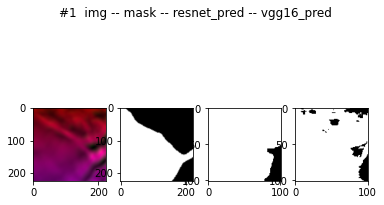

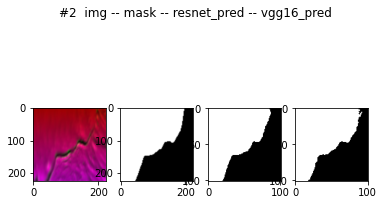

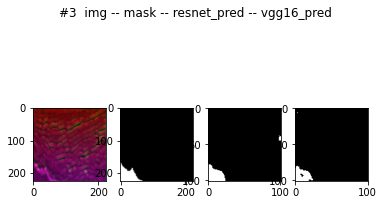

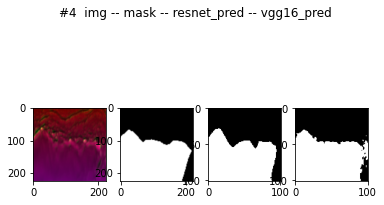

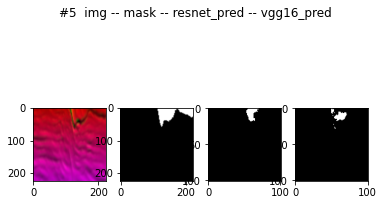

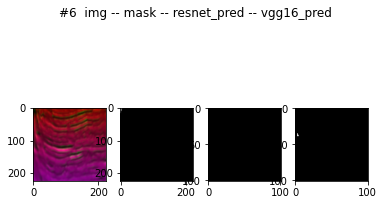

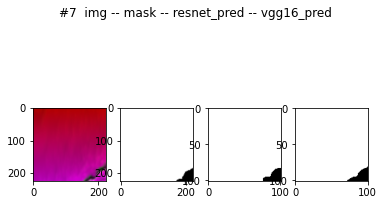

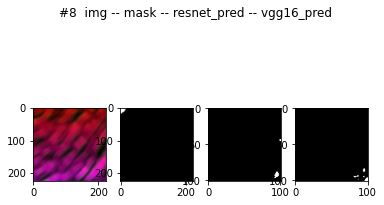

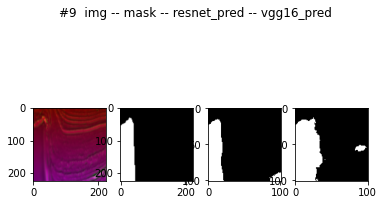

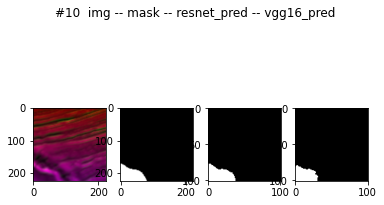

In [33]:
count = 0
for img, mask, resnet_pred, vgg16_pred in zip(images, true_masks, resnet_preds, vgg16_preds):
    count += 1
    fig, ax = plt.subplots(1, 4)
    fig.suptitle(f'#{count}  img -- mask -- resnet_pred -- vgg16_pred')
    for i, resource in enumerate([img,mask,resnet_pred, vgg16_pred]):
        ax[i].imshow(resource, cmap='gray')
    plt.show()

### NOTE:
**Comparing training and validating result (10 epoch)**
- Resnet50: loss: 0.3801 - my_iou_metric: 0.5820 - val_loss: 0.4308 - val_my_iou_metric: 0.5660
- VGG16: loss: 0.4983 - my_iou_metric: 0.4885 - val_loss: 0.4713 - val_my_iou_metric: 0.5025
  
Seems that Resnet50 have better result overall, we can also see this from the prediction images

## Extra
Threshold optimization

### Resnet 50

In [34]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [35]:
val_preds = resnet.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

In [36]:
# Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


In [37]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.5960 at threshold: 0.480


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.580029
std,0.204939,0.017620
min,0.200000,0.528500
25%,0.370000,0.571750
50%,0.540000,0.588500
75%,0.710000,0.592250
max,0.880000,0.596000


<AxesSubplot:xlabel='threshold'>

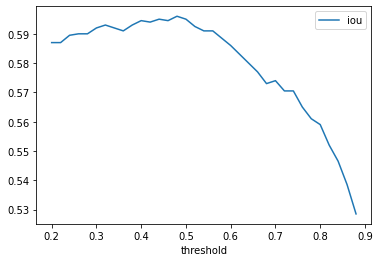

In [38]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

### VGG16

In [39]:
val_preds = vgg16.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))

In [40]:
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:27<00:00,  1.26it/s]


In [41]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.5090 at threshold: 0.520


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.497729
std,0.204939,0.009963
min,0.200000,0.468000
25%,0.370000,0.494500
50%,0.540000,0.501000
75%,0.710000,0.505250
max,0.880000,0.509000


<AxesSubplot:xlabel='threshold'>

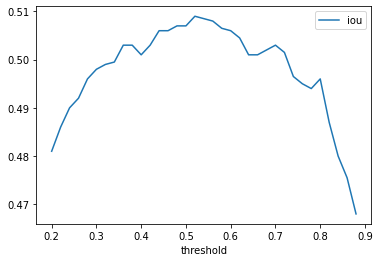

In [42]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

## Conclusion
- As seen from result the respective best threshold is ~0.48 and 0.52 for each model
- And the fact that IOU decrease as we go too close to 1 and 0 means that model is performing correctly